# SAXS&WAXS pipeline for data reduction, e.g.,  to convert 2D scattering patterns to 1D curves (q-Iq, ang-Iang) etc.


## Overview

* Setup: load packages/setup path
* Load calibration h5 file (genreated by calibration pipeline) to load Mask and beamline parameters
* Check one data and convert scattering data to q-phi map, q-Iq, ang-Iang
* Find the interested dataset and do batch reduction
* Produce images (png format)
* Export results to a hdf file 
 

### DEV
* V0: Initialize the pipeline (2019/10/26 by YG yuzhang@bnl.gov)
* V1: Develop the pyScatt package and correct  a bug in qphi analysis (2019/11/8 by YG yuzhang@bnl.gov)
* V2: Make multi-q cut and angle cut (2019/11/20 by YG)


 

## TODLIST
* 1): Put codes into a package (Done!)

# Load Package

In [2]:
%matplotlib notebook
from pyScatt.packages import *
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
#%matplotlib inline

# Setup Paths

In [3]:
####
username = 'yuzhang'


inDir = '/home/%s/Test_SAXS/Data/'%username
outDir = '/home/%s/Test_SAXS/Results/'%username




# Load Seup_pargs and Mask

In [4]:
setup_pargs_h5 =  outDir + 'SAXS_setup_pargs_test.h5'

In [5]:

md_saxs  = h5todict( setup_pargs_h5 )
setup_pargs = md_saxs['md']
setup_pargs['setup_pargs_h5'] = setup_pargs_h5
mask = md_saxs['mask'] 
center = setup_pargs['center']
dpix = setup_pargs['dpix']
lambda_ = setup_pargs['lambda_']
Ldet = setup_pargs['Ldet']
cx,cy=center  



In [6]:
setup_pargs

{'Ldet': 5065.0,
 'center': array([605, 753]),
 'dpix': 0.17200000000000001,
 'exposuretime': 0.1,
 'filename': '/home/yuzhang/Test_SAXS/Data/AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_saxs.tiff',
 'lambda_': 0.9184,
 'path': '/home/yuzhang/Test_SAXS/Results/',
 'timeperframe': 0.1,
 'uid': 'sid=xx',
 'setup_pargs_h5': '/home/yuzhang/Test_SAXS/Results/SAXS_setup_pargs_test.h5'}

<IPython.core.display.Javascript object>


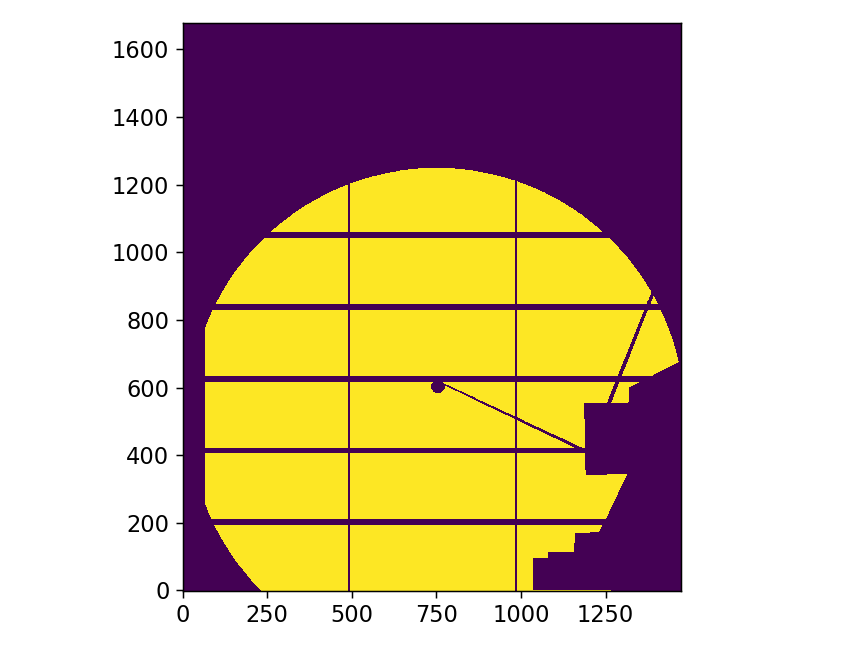

In [7]:
show_img(mask, show_colorbar=False, aspect=1)

# Check Filenames in inDir

In [8]:
tifs = ls_dir( inDir , have_list=[ ], exclude_list=[ 'waxs' ])
print(len(tifs))
tifs

15


array(['AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_saxs.tiff_q_Iq.csv',
       'Pilatus2M_current-mask.png',
       'f3b03825-edfa-43f3-b333_000003.tiff',
       'f3b03825-edfa-43f3-b333_000002.tiff',
       'AgBH_cali_13.5kev_x-17.000_y-2.170_1.00s_2608570_saxs.tiff',
       'AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_saxs.tiff',
       'FL_1024Morn_F1_x0.100_y0.150_0.10s_2605949_saxs.tiff',
       'Pilatus2M_gaps-mask.png',
       'FL_1026Morn_F2_x0.000_y0.000_1.00s_2607309_saxs.tiff',
       'Pilatus800_current-mask.png',
       'AgBH_cali_13.5kev_x-17.000_y-2.170_5.00s_2608571_q_Iq.csv',
       'FL_1024Morn_F1_x0.100_y0.150_0.10s_2605950_saxs.tiff',
       'Pilatus800_custom-mask.png',
       'f3b03825-edfa-43f3-b333_000001.tiff',
       'FL_1024Ngt_10nmSP_Form_Factor_x-0.900_y-0.400_5.00s_2606361_saxs.tiff'],
      dtype='<U69')

# Setup Data Analysis Parameters Using One Data

In [9]:
fp = 'f3b03825-edfa-43f3-b333_000002.tiff'

In [10]:
img_ = get_cms_img( fp, inDir ) 
img = img_ * mask
setup_pargs['filename'] = inDir + fp

In [11]:
img_zoom_half_width = 300  # define a rectangle region of the image with 2*cw width around beam center for plot. 
                       # only this region will be saved to the exported h5 file


<IPython.core.display.Javascript object>


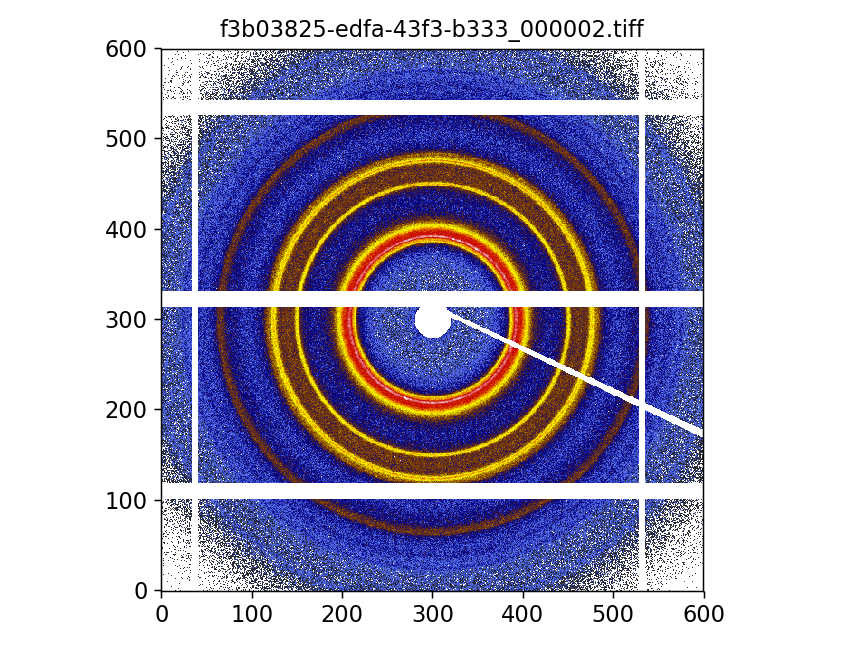

In [12]:
show_img( img[cx-img_zoom_half_width:cx+img_zoom_half_width,cy-img_zoom_half_width:cy+img_zoom_half_width], 
         logs=True, aspect= 1, cmap=  cmap_hdr_goldish, image_name= fp[:], save=True,path=outDir)

## Do Circular Average

In [13]:
print_dict( setup_pargs )

Ldet--> 5065.0
center--> [605 753]
dpix--> 0.17200000000000001
exposuretime--> 0.1
filename--> /home/yuzhang/Test_SAXS/Data/f3b03825-edfa-43f3-b333_000002.tiff
lambda_--> 0.9184
path--> /home/yuzhang/Test_SAXS/Results/
timeperframe--> 0.1
uid--> sid=xx
setup_pargs_h5--> /home/yuzhang/Test_SAXS/Results/SAXS_setup_pargs_test.h5


In [14]:
qp0, iq0, q0 = get_circular_average( img, mask , pargs=setup_pargs,save= False  )
df_ciravg = trans_data_to_pd( [ q0, iq0], label=[ 'q_saxs', 'iq_saxs'] ,dtype= 'list' ) 
df_ciravg.to_csv( outDir + '%s_q_Iq.csv'%fp )

In [15]:
#df_ciravg

<IPython.core.display.Javascript object>


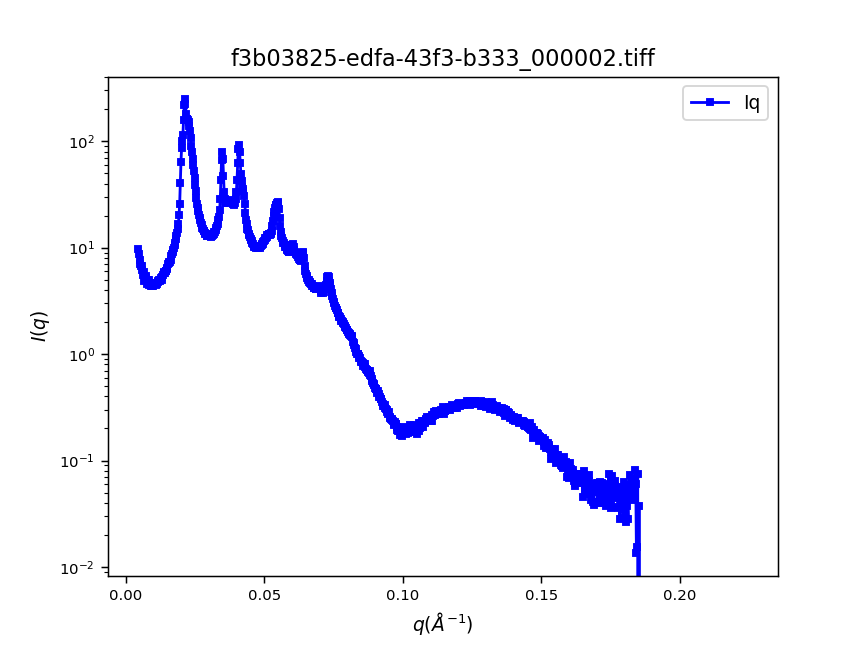

Text(0, 0.5, '$I(q)$')

In [16]:
fig,ax=plt.subplots()
plot1D( x = q0, y = iq0, yerr= None, logy= True, #xlim=[0.002, 0.12],  
       c='b', m = 's',legend='Iq', markersize= 3,  ax=ax,)  
ax.set_title (  fp[:])
ax.set_xlabel (r'$q (\AA^{-1})$')
ax.set_ylabel ( r'$I(q)$' )

## Convert this image to q-phi plot

* Define the parameters for bin numbe of q and  phi,  bin range of q and phi

In [17]:
bin_num_q = 500  
bin_num_phi =  180
bin_q_range = [0.001, 0.12] 
bin_phi_range = [-180, 180]


* Get q-map and phi-map for remesh 

In [18]:
bins = bin_num_q, bin_num_phi
qang_range=  [ bin_q_range,  bin_phi_range ] 
q_map_ = utils.radial_grid( center, img.shape, pixel_size= [dpix,dpix] )
q_map =  utils.twotheta_to_q( utils.radius_to_twotheta(Ldet, q_map_),lambda_ )
phi_map = np.degrees( angle_grid(center, img.shape,) )

* Do conversion

In [19]:
sqphi,  qs,  phis = qphiavg(img, q_map=q_map, phi_map=phi_map, mask=mask, bins= bins,
        origin= center, range=qang_range, statistic='mean') 
sqphim,  qsm,  phism = qphiavg( mask, q_map=q_map, phi_map=phi_map, mask=mask, bins= bins,
        origin= center, range=qang_range, statistic='mean') 
ma  = np.isnan( sqphim ) 

/home/yuzhang/conda_envs/pyScattering/lib/python3.7/site-packages/skbeam/core/accumulators/binned_statistic.py:349: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.result = self.result[core]


* plot qphi remeshed image

<IPython.core.display.Javascript object>


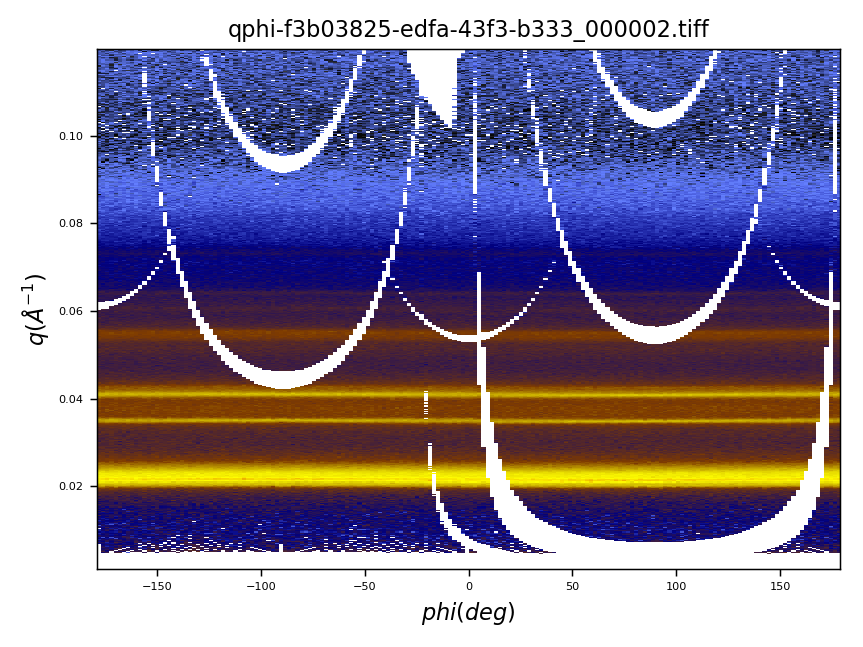

In [20]:
show_img(  sqphi,  logs=True, aspect= None, cmap=  cmap_hdr_goldish,#cmap_hdr_albula, 
           vmin=0.01,vmax=1e4, 
           tick_size=6, colorbar_fontsize=6, lab_fontsize=12,
           show_ticks= True, title_size=8, 
           extent=[phis[0], phis[-1], qs[0], qs[-1]], 
           xlabel=r'$phi (deg)$', ylabel=  r'$q (\AA^{-1})$',
           image_name= 'qphi-' + fp, save= False, path=outDir  )   

## Get q-Iq for multi-phis  based on the converted qphi 

* average all angles if not given the angle cut edge 

In [21]:
#acut_cen = None #angle cut position, if None, do all angle average, otherwise, do avaerge around the cut with awid
acut_wid = 40

In [22]:
acut_cen, acut_edge =  get_angle_edge(   acut_wid   )
#acut_edge= np.array( [[ -180,180]] )
#acut_cen = np.average( acut_edge, axis=1)
print( 'The angle-cut edges are: \n%s.'%acut_edge)
iqs, label_iqs = get_ang_cut_qiq(  sqphi, qs, phis, mask=ma, acut_edge = acut_edge  ) 
df_iqs = trans_data_to_pd( iqs, label=label_iqs ,dtype= 'array' )   
df_iqs.to_csv( outDir + '%s_q_iqs.csv'%fp )
Nang = len(acut_edge)

The angle-cut edges are: 
[[-180. -140.]
 [-140. -100.]
 [-100.  -60.]
 [ -60.  -20.]
 [ -20.   20.]
 [  20.   60.]
 [  60.  100.]
 [ 100.  140.]
 [ 140.  180.]].


## Get ang-Iang for multi-q based on the converted qphi 

* average around the Iq peak position if not given the q-edge

In [23]:
qcut_cen = None #q cut position, if None, do all q average around the first peak, otherwise, do avaerge around the qcut with awid
qcut_wid = 0.0005
search_qmax_range = [0.01, 0.1 ]
#or provide the qcut_cen
qcut_cen = np.array( [ 0.0089, 0.012, 0.0177, 0.0356, 0.0448 ] )



In [24]:
if qcut_cen is None:
    q1, q2 = find_index( q0, search_qmax_range[0]  ),  find_index( q0,search_qmax_range[1]  )
    qind_max = np.argmax( iq0[q1 : q2 ] ) + q1
    qcut_cen = np.array( [  q0[ qind_max  ]  ] ) 
qcut_edge=  np.array( [  [qc - qcut_wid, qc + qcut_wid ]   for qc in qcut_cen ] ) #in angstron
#qcut_edge = np.array( [[0,.10]] )
#qcut_cen = np.average( qcut_edge, axis=1)
Nq = len( qcut_edge)  
print( 'The q-cut edges are: \n%s.'%qcut_edge)
iphis, label_iphis = get_q_cut_iphi(  sqphi, qs, phis, mask=ma, qcut_edge=qcut_edge   )
df_iphis = trans_data_to_pd( iphis, label=label_iphis ,dtype= 'array' )   
df_iphis.to_csv( outDir + '%s_q_iphis.csv'%fp )
 


The q-cut edges are: 
[[0.0084 0.0094]
 [0.0115 0.0125]
 [0.0172 0.0182]
 [0.0351 0.0361]
 [0.0443 0.0453]].


## Plot qphi analysis results

* plot qphi map

<IPython.core.display.Javascript object>


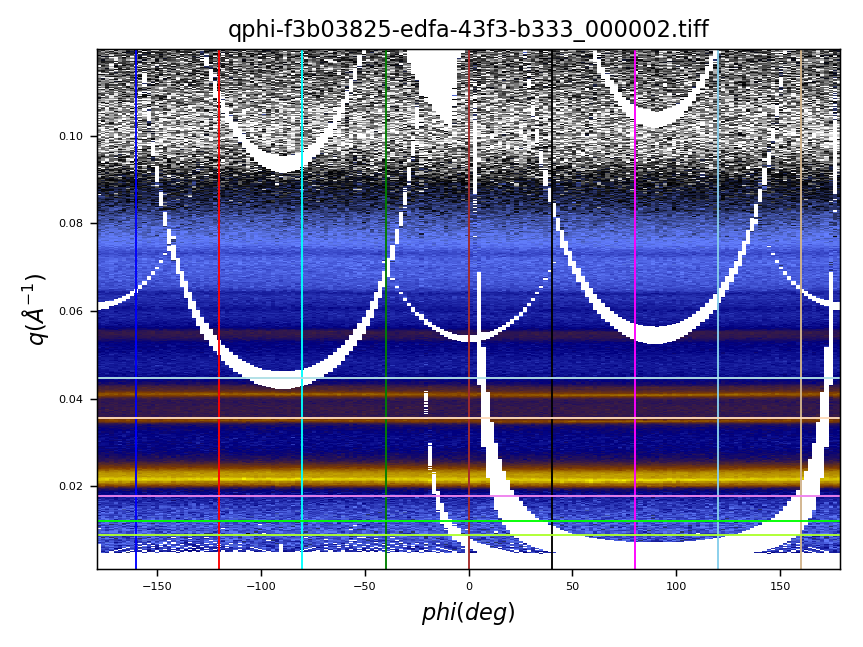

In [25]:
fig, ax = plt.subplots()
show_img(  sqphi,
           ax=[fig,ax], logs=True, aspect= None, cmap=  cmap_hdr_goldish,
           vmin= 1e-1,vmax=1e4,  
           tick_size=6, colorbar_fontsize=6, lab_fontsize=12,
           show_ticks= True, title_size=8,            
           extent=[phis[0], phis[-1], qs[0], qs[-1]], 
           xlabel=r'$phi (deg)$', ylabel=  r'$q (\AA^{-1})$',
           image_name= 'qphi-' + fp )  
if acut_cen is not None:
    for i, c in enumerate( acut_cen ): 
        ax.vlines(   c, qs[0], qs[-1], colors= colors[i] , linewidth= 1    )
for j, c in enumerate( qcut_cen ):         
        ax.hlines(   c,  phis[0], phis[-1], colors= colors[i+j+1] , linewidth= 1  )        


* plot q-iq

In [26]:
iq_plot_xlim = [0.002, 0.12]

<IPython.core.display.Javascript object>


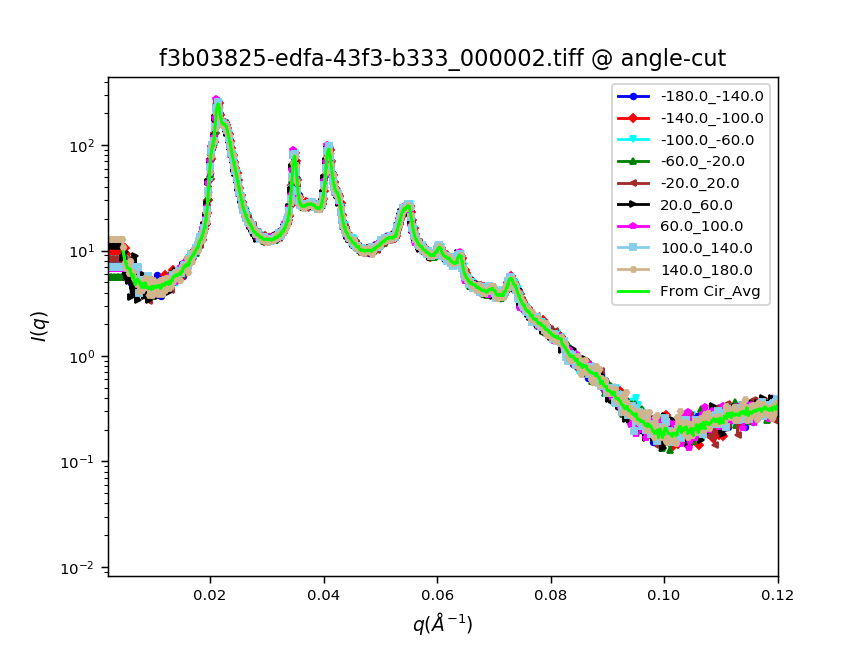

Text(0, 0.5, '$I(q)$')

In [27]:
fig,ax=plt.subplots()
for i in range( Nang):    
    plot1D( x = qs, y = iqs[:,i+1], yerr= None, logy= True, xlim=iq_plot_xlim,  ax=ax, legend=label_iqs[i+1],
                   c=colors[i], m = markers[i],   markersize= 3) 
plot1D( x = q0, y = iq0, yerr= None, logy= True, xlim=iq_plot_xlim,  ax=ax, legend='From Cir_Avg',
       c=colors[i+2], m = markers[i+2],   markersize= 1, legend_size=8)
ax.set_title (  fp[:] + ' @ angle-cut')
ax.set_xlabel (r'$q (\AA^{-1})$')
ax.set_ylabel ( r'$I(q)$' )

* plot phi-Iphi

<IPython.core.display.Javascript object>


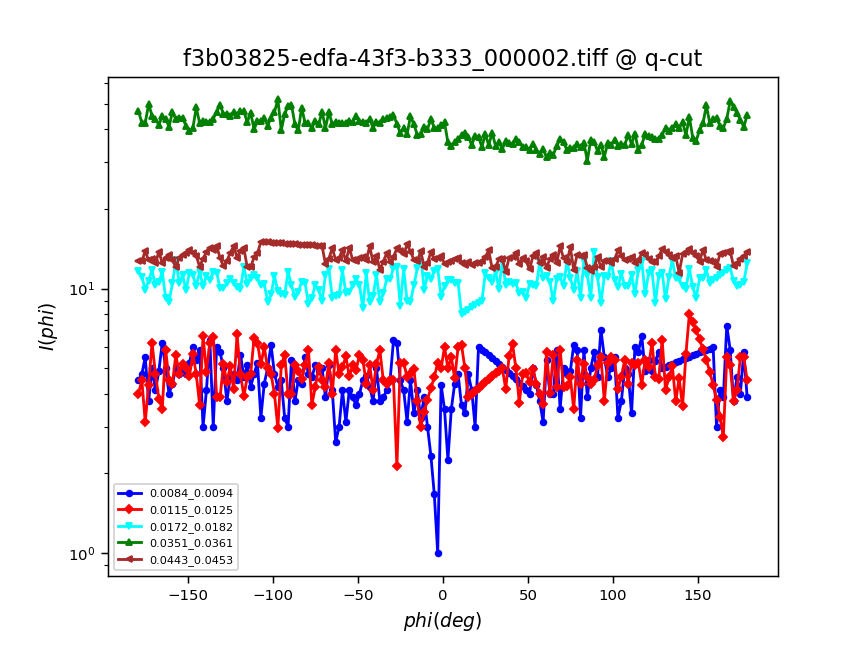

Text(0, 0.5, '$I(phi)$')

In [28]:
fig,ax=plt.subplots()
for i in range( Nq):    
    plot1D( x = phis, y = iphis[:,i+1], yerr= None, logy= True,   ax=ax, 
           legend=label_iphis[i+1],  c=colors[i], m = markers[i],   markersize= 3, legend_size = 6) 
ax.set_title (  fp[:] + ' @ q-cut')
ax.set_xlabel (r'$phi (deg)$')
ax.set_ylabel ( r'$I(phi)$' ) 

In [28]:
setup_pargs

{'Ldet': 4890.0,
 'center': array([507, 588]),
 'dpix': 0.17200000000000001,
 'filename': '/home/yuzhang/XScattering/PDF_Project/Data/L30_5s_3_SAXS_SC.tif',
 'lambda_': 0.9184,
 'setup_pargs_h5': '/home/yuzhang/XScattering/PDF_Project/Results/SAXS_setup_pargs_FangCb.h5'}

# Define the parameter for papermill

In [30]:
uid_list =  [ 'f3b03825-edfa-43f3-b333_000001.tiff'   ]



# Run reduction using the parameters defined above

In [31]:
data_reduction_pargs={}
data_reduction_pargs['img_zoom_half_width'] = img_zoom_half_width
data_reduction_pargs['bin_num_q'] = bin_num_q
data_reduction_pargs['bin_num_phi']=bin_num_phi
data_reduction_pargs['bin_q_range']=bin_q_range
data_reduction_pargs['bin_phi_range']=bin_phi_range
data_reduction_pargs['acut_edge'] =   acut_edge
data_reduction_pargs['qcut_edge'] =   qcut_edge
data_reduction_pargs['outDir'] = outDir
data_reduction_pargs['inDir'] = inDir

data_plot_pargs={}
data_plot_pargs['xlim'] = iq_plot_xlim


#data_reduction_pargs = None

0---> f3b03825-edfa-43f3-b333_000001.tiff
The results are exported as a h5 file: /home/yuzhang/Test_SAXS/Results/f3b03825-edfa-43f3-b333_000001.tiff.h5.


<IPython.core.display.Javascript object>


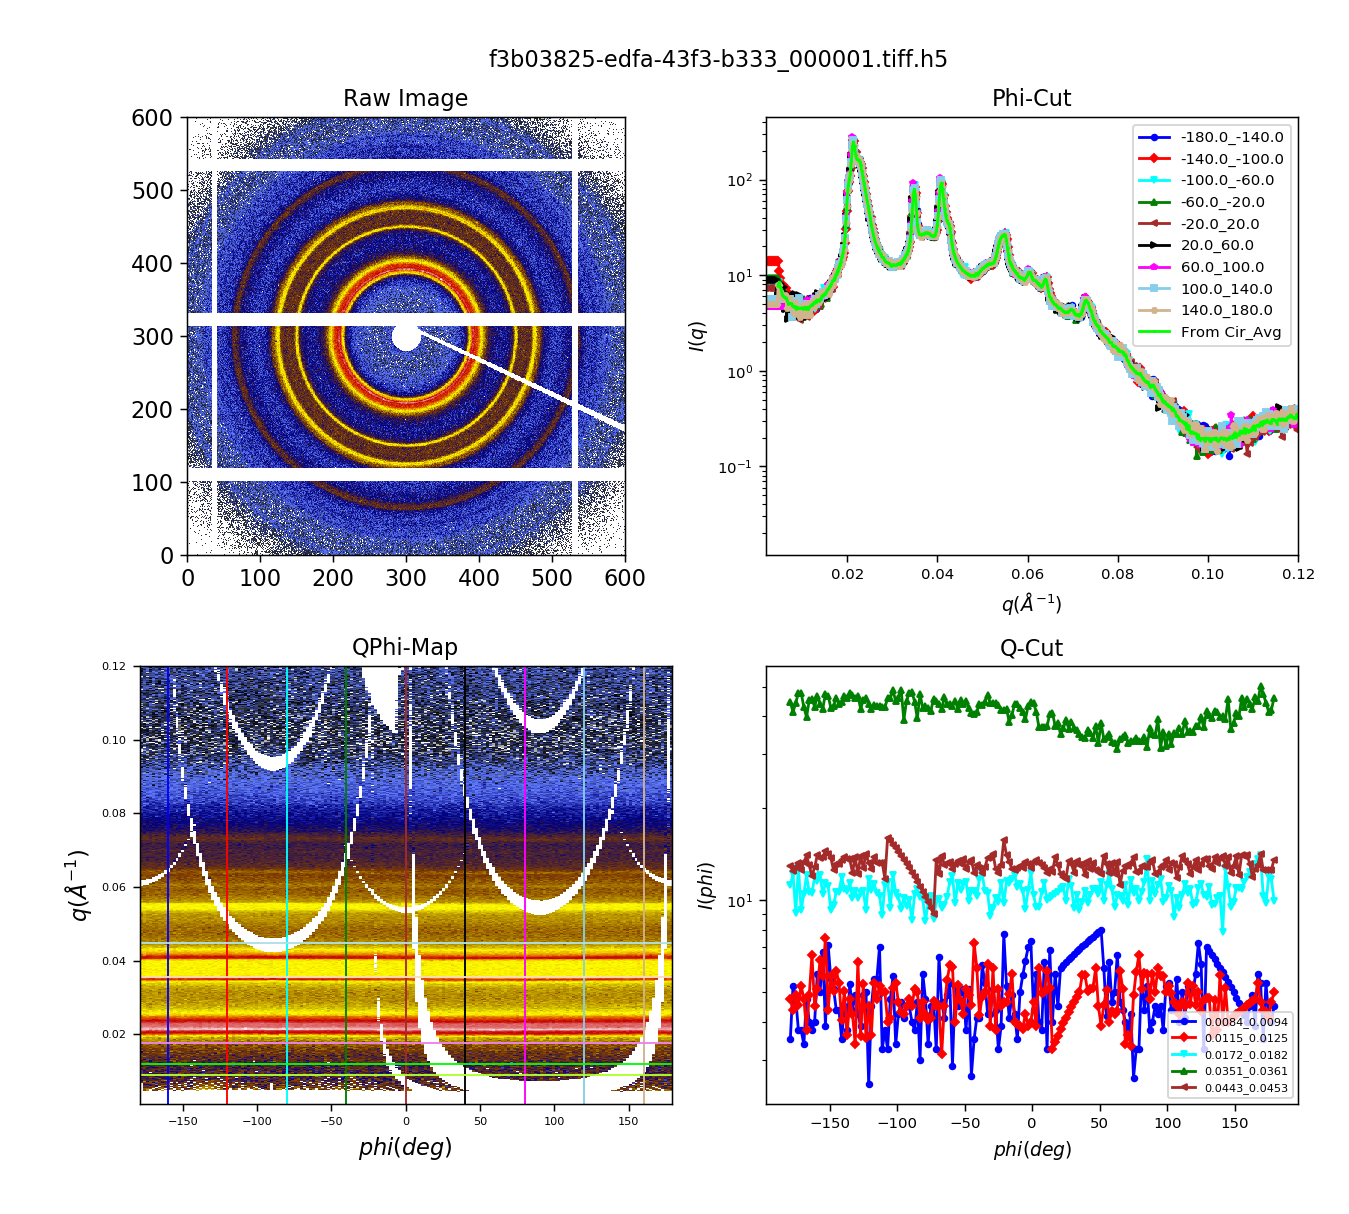

Total time: 2.735 sec


In [32]:
t0 = time.time() 
for i, fp in enumerate( uid_list ):     
    print('%s---> %s'%(i, fp) )    
    #try:
    if True:    
        img = get_cms_img( fp, inDir ) * mask
        img = np.abs(img)        
        data_reduction_pargs['filename'] = fp
        res = Run_SAXS_Data_Reduction( img, mask, setup_pargs, data_reduction_pargs = data_reduction_pargs, 
                                       overwrite_h5= True, verbose=False ) 
        Plot_SAXS_Data_Reduction( res['md']['io']['out']['filename'] , data_plot_pargs= data_plot_pargs ) 
        
        #print(fout)
    #except:
    #    print('Something wrong with this data: %s'%fp) 
run_time( t0 )        

# The End